### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes (including units), and provide a legend and colorbar, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Before submitting, check your code by executing: Kernel -> Restart & run all.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL WS 2018/2019 - Exercise Sheet #02

#### Name(s):

In [1]:
# % matplotlib inline

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Preparation: Loading Data

In [2]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 1: Scatter Plot of 2D Features  (8 points)

Make a scatter plot of the two distributions - *targets* and *nontargets*, one dot for each trial. On the `x`-axis, plot the value of channel Cz at `t` = 380 ms, and at the `y`-axis the value of PO3 at `t` = 300 ms. *(You may refer to the results of sheet 01 for the reason of this choice.)*
Draw for both distributions the two principal axes, with the lengths of the axes being the standard deviation of the data in that direction. 
Draw also the corresponding ellipses. **Hint:** You can get that with a transformation of the unit circle as on the slide *Illustration of Multiplication ...*.

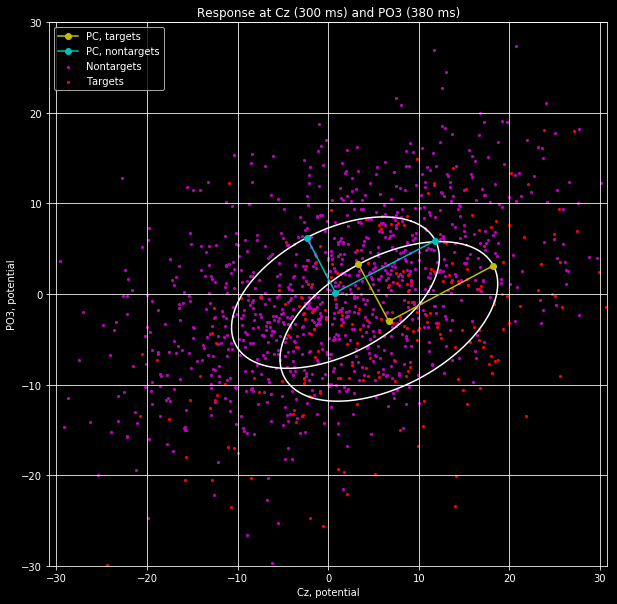

In [10]:
def ellipse_decomp(x,y):
    # Input: x, y numpy arrays of a set of points (according to x and y axis)
    # 
    # Return: ellipse: 2D matrix of the standard deviation ellipse, 
    #         x, y: lists of the eigenvectors with the mean, split into x and y positions.
    t = np.linspace(0, np.pi*2,100) #start:0, stop: 2*pi, number of sample 100
    # t = array of equaliy distributed values for the elipse 100,
    circle = np.array([np.cos(t), np.sin(t)]) # circle

    matrix = np.array([x, y]) #R^n*m  n=2 m = a lot
    cov_matrix = np.cov(matrix) #R^n*m n=2 m=2
    # cov_matrix sum_t=1,^T((nuh-x)(nuh-y)^T)
    eigen_value, eigen_vector = np.linalg.eig(cov_matrix)
    # why is my eigenvalue a vector
    # why is my eigenvector a matrix?
    # calculate eigenvalue and eigenvector
    D = np.diag(np.sqrt(eigen_value)) # sqrt of eigen value 
    covroot = np.dot(eigen_vector, np.dot(D, eigen_vector))
    # covroot is a R^n*m n=2 m=2 matrix
    # what is np.dot?
    
    mean = np.mean(matrix,axis=1)
    # what is axis 1 or 0 
    elli = np.dot(covroot, circle)
    elli[0] += mean[0]
    elli[1] += mean[1]
    
    vec1 = np.dot(covroot, eigen_vector[0])
    vec2 = np.dot(covroot, eigen_vector[1])
    
    x, y = np.split([vec2+mean, mean, vec1+mean], [-1], axis=1)
    return elli, x, y

ival= [-100, 1000]
ref_ival= [-100, 0]
chans = ['Cz', 'PO3']

epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)
epo = bci.baseline(epo, epo_t, ref_ival)

timeCz = np.where(epo_t == 380) #index of epo_t: 48 
timePO3 = np.where(epo_t == 300) #index of epo_t: 40

iCz = clab.index(chans[0]) #22
iPO3 = clab.index(chans[1]) #48

Cz_values = epo[timeCz, iCz, mrk_class == 1] #array of value (1, 982)
PO3_values = epo[timePO3, iPO3, mrk_class == 1] #array of value (1, 982)
Cz_targets = epo[timeCz, iCz, mrk_class == 0] #array of values (1,218)
PO3_targets = epo[timePO3, iPO3, mrk_class == 0] #array of values (1,218)

#### MAKING THE ELLIPSES
ellipseT, x1, y1 = ellipse_decomp(Cz_targets[0], PO3_targets[0])
ellipseN, x2, y2 = ellipse_decomp(Cz_values[0], PO3_values[0])

plt.style.use('dark_background')
hf = plt.figure(figsize=(10,10))
plt.grid()
plt.title('Response at Cz (300 ms) and PO3 (380 ms)')

plt.scatter(Cz_values, PO3_values, s=10, c = 'm', marker = 'o', label='Nontargets', linewidths=0)
plt.scatter(Cz_targets, PO3_targets, s=10, c = 'r', marker = 'o', label='Targets', linewidths=0)

plt.plot(ellipseT[0], ellipseT[1], 'w')
plt.plot(ellipseN[0], ellipseN[1], 'w')

plt.plot(x1, y1, 'yo-', label ='PC, targets')

plt.plot(x2, y2, 'co-', label = 'PC, nontargets')

plt.axis('equal')
plt.xlim((-30,30))
plt.ylim((-30,30))
plt.ylabel('PO3, potential')
plt.xlabel('Cz, potential')
plt.legend()
plt.show()



## Exercise 2: Covariances and Eigenvalues  (7 points)

Calculate the channelwise covariance matrices (channel `x` channel) of the data for time point 380 ms for both classes (`np.cov`) and visualize them (`plt.imshow`). 
Perform an Eigenvalue decomposition (`np.linalg.eigh`) of the covariance matrices and plot (again class-wise) the eigenvalue spectrum. Then determine the four principle components (Eigenvectors) for each class that correspond to the largest Eigenvalues and display them as scalp maps (function `scalpmap` provided in the `bci_minitoolbox`).

In [39]:
"""
Take the entire matrix, calculate the covariance between all and all, NOT PAIRWISE. Do eigenvalue decomp., 
take the four largest ones -> take their vectors (which now has 55 entries), and display in scalpmap.  
"""
### Suffix T and N corresponds to target and non. 
### Could of course avoid this redundancy, but nice to have the plots side by side. 

targetdata = epo[t, :, mrk_class == 0][0]
print(targetdata)
nontargetd = epo[t, :, mrk_class == 1][0]

covT = np.cov(targetdata.T)
covN = np.cov(nontargetd.T)

eigvalT, eigvecT = np.linalg.eig(covT)
eigvalN, eigvecN = np.linalg.eig(covN)

sortedeigT = -np.sort(-eigvalT)
sortedeigN = -np.sort(-eigvalN)

indicesT = [np.where(eigvalT == sortedeigT[j])[0][0] for j in range(4)]
indicesN = [np.where(eigvalN == sortedeigN[j])[0][0] for j in range(4)]

print("Strongest channels, targets: ", indicesT)
print("Strongest channels, nontargets: ", indicesN)

# sortedeig = eigval  # they seem to follow some sorted pattern, going from low to high (typical for eigenvalues)

### Plotting the covariance matrices
plt.figure()
plt.title("Covariance accross channels for targets")
picture = plt.imshow(covT)
picture.set_cmap('jet')
plt.colorbar(label="Covariance")

plt.figure()
plt.title("Covariance accross channels for nontargets")
picture = plt.imshow(covN)
picture.set_cmap('jet')
plt.colorbar(label="Covariance")

### Plotting the eigenvalues spectrum
### A logarithmic y-axis seems reasonable given the range
plt.figure()
plt.title("Covariance matrix eigenvalues")
plt.semilogy(np.arange(len(sortedeigT)), sortedeigT, 'r', label="Targets")
plt.semilogy(np.arange(len(sortedeigN)), sortedeigN, 'y', label="Nontargets")
plt.ylabel("Eigenvalues")
plt.legend()

### Plotting the scalpmaps
for j in range(4):
    vectorT = eigvecT[indicesT[j]]
    vectorN = eigvecN[indicesN[j]]
    
    # Here we scale for the max entry in the two eigenvectors to be plotted, for comparison.  
    maxentr = np.max(np.abs(np.array([vectorT, vectorN])))
    color = [-maxentr, maxentr]
      
    plt.figure()
    bci.scalpmap(mnt, vectorT, clim=color, cb_label = 'Targets, eigenvalue '+str(j+1)+": "+str(round(eigvalT[j])))
    plt.figure()
    bci.scalpmap(mnt, vectorN, clim=color, cb_label = 'Nontargets eigenvalue '+str(j+1)+": "+str(round(eigvalN[j])))

plt.show()

NameError: name 't' is not defined